## Preparation

In [1]:
# Clone repository
%%shell
if [ ! -e nanosam ]; then
    git clone https://github.com/NVIDIA-AI-IOT/nanosam.git
fi

Cloning into 'nanosam'...
remote: Enumerating objects: 1309, done.
remote: Counting objects: 100% (145/145), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 1309 (delta 126), reused 99 (delta 99), pack-reused 1164
Receiving objects: 100% (1309/1309), 97.56 MiB | 12.80 MiB/s, done.
Resolving deltas: 100% (750/750), done.


In [2]:
# Change working directory
%cd /content/nanosam

/content/nanosam


In [3]:
# Install ONNX-Runtime library
%%shell
if type nvidia-smi > /dev/null 2>&1; then
    pip install onnxruntime-gpu==1.17 --extra-index-url https://aiinfra.pkgs.visualstudio.com/PublicPackages/_packaging/onnxruntime-cuda-12/pypi/simple/
else
    pip install onnxruntime
fi

Looking in indexes: https://pypi.org/simple, https://aiinfra.pkgs.visualstudio.com/PublicPackages/_packaging/onnxruntime-cuda-12/pypi/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.9/192.9 MB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 8.9 MB/s eta 0:00:00


In [4]:
# Download model files
%%shell
mkdir -p data
if [ ! -e data/mobile_sam_mask_decoder.onnx ]; then
    curl -kL -o data/mobile_sam_mask_decoder.onnx 'https://drive.google.com/uc?export=download&id=1jYNvnseTL49SNRx9PDcbkZ9DwsY8up7n'
fi
if [ ! -e data/resnet18_image_encoder.onnx ]; then
    curl -kL -o data/resnet18_image_encoder.onnx 'https://drive.google.com/uc?export=download&id=14-SsvoaTl-esC3JOzomHDnI9OGgdO2OR'
fi

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100 15.7M  100 15.7M    0     0  2322k      0  0:00:06  0:00:06 --:--:-- 4712k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100 60.3M  100 60.3M    0     0  6473k      0  0:00:09  0:00:09 --:--:-- 14.9M


## Code modification

Modify the contents of `nanosam/utils/predictor.py` to make the Predictor class compatible with ONNX Runtime.

Some errors will occur when code in the nanosam repository tries to import a library that is not installed.

To avoid this error, we prepare dummy modules in advance.

In [6]:
import types
import sys

# prepare dummy module object to skip import torch2trt
torch2trt = types.ModuleType("torch2trt")
class TRTModule:
    def __init__(self, *args, **kwargs):
        raise ImportError("torch2trt is not available")
torch2trt.TRTModule = TRTModule
sys.modules["torch2trt"] = torch2trt

# prepare dummy module object to skip import tensorrt
sys.modules["tensorrt"] = types.ModuleType("tensorrt")

from nanosam.utils.predictor import preprocess_points, upscale_mask

Redefine preprocess_image with slight modifications to support operation at CPU runtime.

In [7]:
import PIL
import torch
import numpy as np

def preprocess_image(image, size: int = 512):
    if isinstance(image, np.ndarray):
        image = PIL.Image.fromarray(image)

    image_mean = torch.tensor([123.675, 116.28, 103.53])[:, None, None]
    image_std = torch.tensor([58.395, 57.12, 57.375])[:, None, None]

    image_pil = image
    aspect_ratio = image_pil.width / image_pil.height
    if aspect_ratio >= 1:
        resize_width = size
        resize_height = int(size / aspect_ratio)
    else:
        resize_height = size
        resize_width = int(size * aspect_ratio)

    image_pil_resized = image_pil.resize((resize_width, resize_height))
    # image_np_resized = np.asarray(image_pil_resized)
    image_np_resized = np.asarray(image_pil_resized).copy() # add copy to resolve UserWarning about non-writable tensors
    image_torch_resized = torch.from_numpy(image_np_resized).permute(2, 0, 1)
    image_torch_resized_normalized = (image_torch_resized.float() - image_mean) / image_std
    image_tensor = torch.zeros((1, 3, size, size))
    image_tensor[0, :, :resize_height, :resize_width] = image_torch_resized_normalized

    # return image_tensor.cuda()
    return image_tensor # disable transfer to cuda device to support CPU runtime

`run_mask_decoder` and `Predictor` will be newly defined because they need significant modification to support ONNX Runtime.

In [8]:
import onnxruntime as ort

def run_mask_decoder(mask_decoder_session, features, points=None, point_labels=None, mask_input=None):
    if points is not None:
        assert point_labels is not None
        assert len(points) == len(point_labels)

    image_point_coords = np.array([points], dtype=np.float32)
    image_point_labels = np.array([point_labels], dtype=np.float32)

    if mask_input is None:
        mask_input = np.zeros((1, 1, 256, 256), dtype=np.float32)
        has_mask_input = np.array([0], dtype=np.float32)
    else:
        has_mask_input = np.array([1], dtype=np.float32)

    iou_predictions, low_res_masks = mask_decoder_session.run(
        ["iou_predictions", "low_res_masks"],
        {
            "image_embeddings": features,
            "point_coords": image_point_coords,
            "point_labels": image_point_labels,
            "mask_input": mask_input,
            "has_mask_input": has_mask_input,
        }
    )
    iou_predictions = torch.from_numpy(iou_predictions.astype(np.float32)).clone()
    low_res_masks = torch.from_numpy(low_res_masks.astype(np.float32)).clone()

    return iou_predictions, low_res_masks


class OnnxNanosamPredictor:
    def __init__(self,
            image_encoder_path: str,
            mask_decoder_path: str,
            image_encoder_size: int = 1024,
            orig_image_encoder_size: int = 1024,
        ):
        self.image_encoder_session = ort.InferenceSession(
            image_encoder_path,
            providers=["CUDAExecutionProvider", "CPUExecutionProvider"]
        )
        self.mask_decoder_session = ort.InferenceSession(
            mask_decoder_path,
            providers=["CUDAExecutionProvider", "CPUExecutionProvider"]
        )
        self.image_encoder_size = image_encoder_size
        self.orig_image_encoder_size = orig_image_encoder_size

    def set_image(self, image):
        self.image = image
        self.image_tensor = preprocess_image(image, self.image_encoder_size)
        self.features = self.image_encoder_session.run(
            ["image_embeddings"],
            {
                "image": self.image_tensor.numpy(),
            }
            )[0]

    def predict(self, points, point_labels, mask_input=None):
        points = preprocess_points(
            points,
            (self.image.height, self.image.width),
            self.orig_image_encoder_size
        )
        mask_iou, low_res_mask = run_mask_decoder(
            self.mask_decoder_session,
            self.features,
            points,
            point_labels,
            mask_input
        )

        hi_res_mask = upscale_mask(
            low_res_mask,
            (self.image.height, self.image.width)
        )

        return hi_res_mask, mask_iou, low_res_mask


## Execution

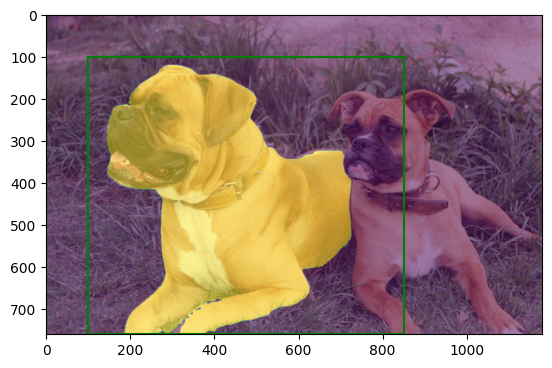

In [9]:
# SPDX-FileCopyrightText: Copyright (c) 2023 NVIDIA CORPORATION & AFFILIATES. All rights reserved.
# SPDX-License-Identifier: Apache-2.0


import matplotlib.pyplot as plt

image_encoder_path = "data/resnet18_image_encoder.onnx"
mask_decoder_path = "data/mobile_sam_mask_decoder.onnx"

# Instantiate ONNX-Runtime predictor
predictor = OnnxNanosamPredictor(
    image_encoder_path,
    mask_decoder_path
)

# Read image and run image encoder
image = PIL.Image.open("assets/dogs.jpg")
predictor.set_image(image)

# Segment using bounding box
bbox = [100, 100, 850, 759]  # x0, y0, x1, y1
points = np.array([
    [bbox[0], bbox[1]],
    [bbox[2], bbox[3]]
])

# Description for point label
# 0: Background point
# 1: Foreground point
# 2: Bounding box top-left
# 3: Bounding box bottom-right
point_labels = np.array([2, 3])

mask, _, _ = predictor.predict(points, point_labels)
mask = (mask[0, 0] > 0).detach().cpu().numpy()

# Draw results
plt.imshow(image)
plt.imshow(mask, alpha=0.5)
x = [bbox[0], bbox[2], bbox[2], bbox[0], bbox[0]]
y = [bbox[1], bbox[1], bbox[3], bbox[3], bbox[1]]
plt.plot(x, y, 'g-')
plt.savefig("data/basic_usage_out.jpg")

Time profiling

In [10]:
# calc prediction time
%%timeit -n 10
predictor.set_image(image)
mask, _, _ = predictor.predict(points, point_labels)

121 ms ± 29.8 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
